In [1]:
import galprime as gp

from photutils import background, segmentation

from astropy.convolution import convolve, Tophat2DKernel, Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats

from scipy import ndimage

import numpy as np

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def gradient_background(grad_min=0.01, grad_max = 0.1, width=151, **kwargs):
    cent_x, cent_y = kwargs.get('cent_x', (width)//2), kwargs.get('cent_y', (width)//2)
    xs, ys = np.mgrid[:width, :width]
    xs -= cent_x
    ys -= cent_y

    grad = (xs * ys)
    grad = grad / np.max(grad) * (grad_max - grad_min) + grad_min
    return grad


gradient_cutouts = gp.Cutouts(cutouts = [gradient_background(grad_max=0.1, cent_x = np.random.randint(151),
                                                             cent_y = np.random.randint(151)) for i in range(20)])

20


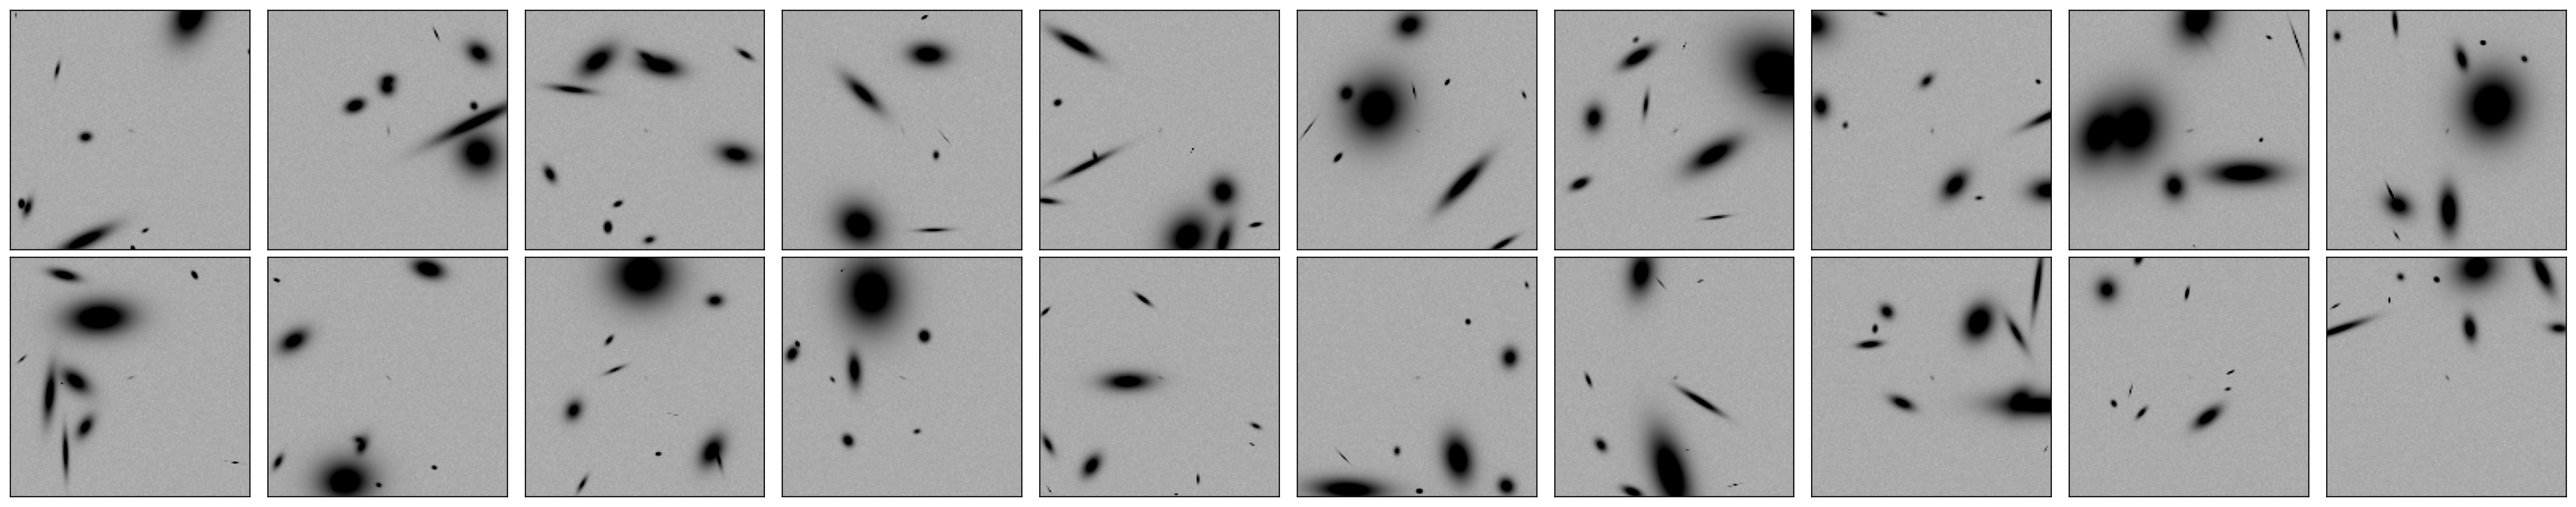

20


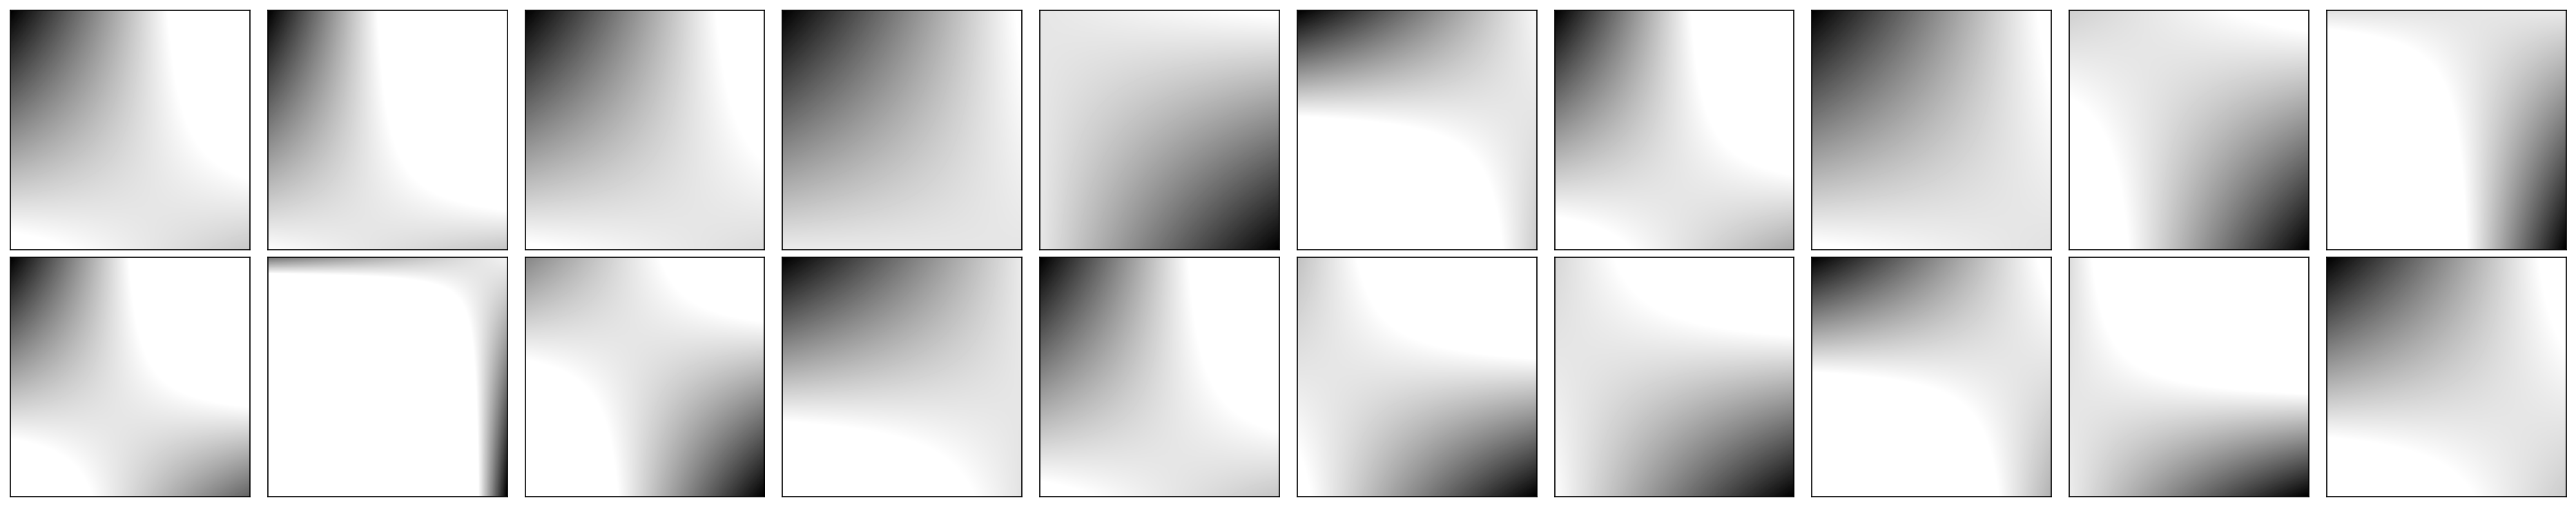

In [3]:
models = gp.gen_sersic_models(n_models=20, width=151, re_range=[0.5, 1], mag_range=[26, 28])
noise_added_models = gp.add_gaussian_noise(models, std=0.01, mean=0.1)
sersic_objects = gp.add_sersic_objects(noise_added_models, min_r=20, reff_range=[0.5, 1])

gp.plotting.show_cutouts(sersic_objects, ncols=10, nrows=2, vmin=-2, vmax=1, method='log')

gp.plotting.show_cutouts(gradient_cutouts, ncols=10, nrows=2, vmin=0, vmax=0.1, method='linear')

20


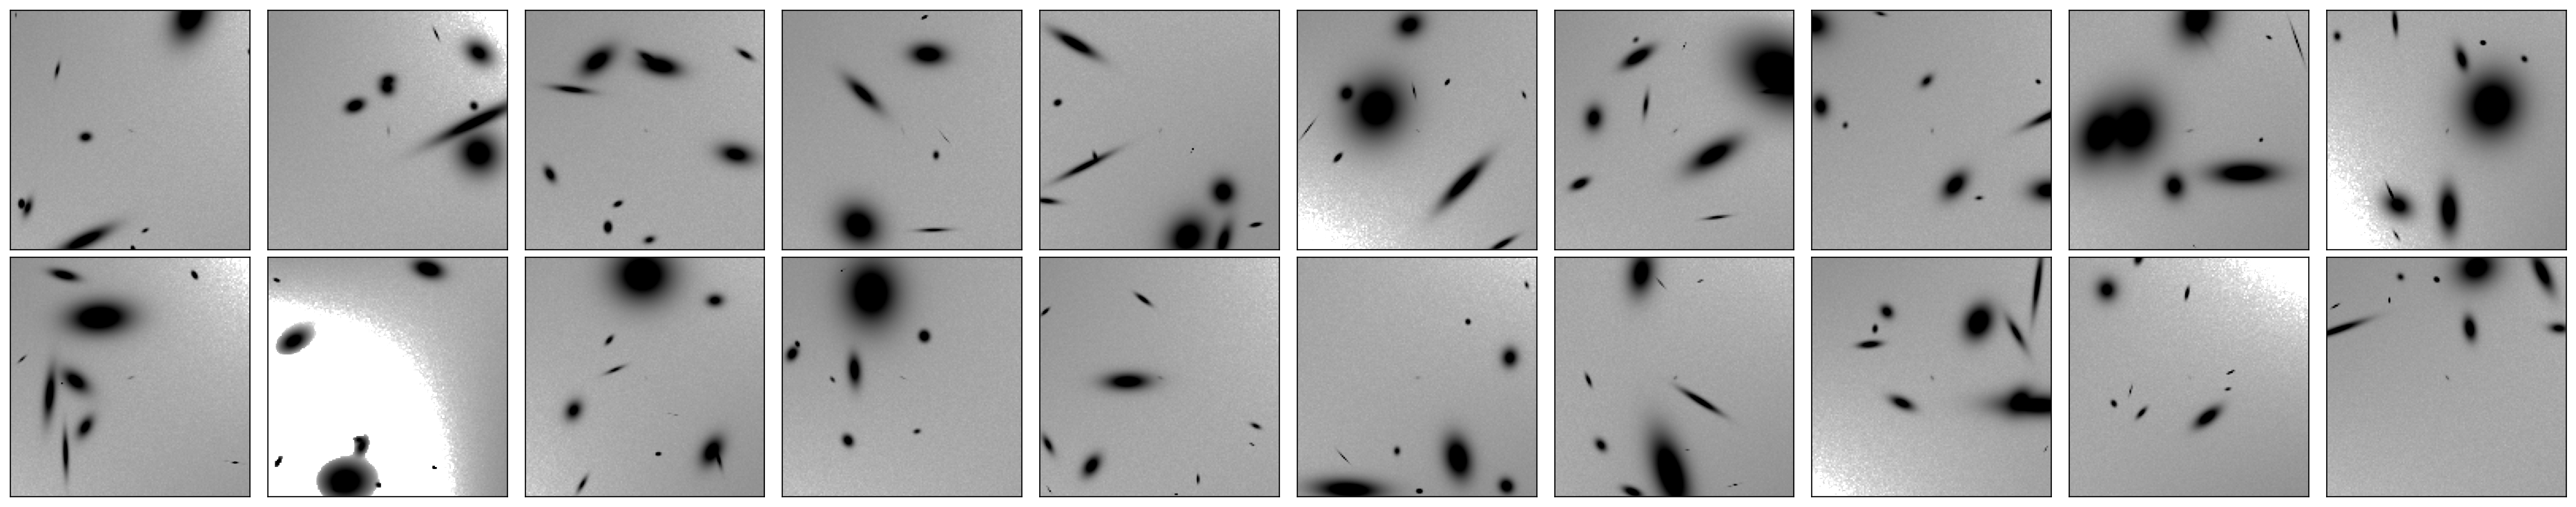

In [4]:
gradient_added_models = sersic_objects.combine(gradient_cutouts, method="direct")
gp.plotting.show_cutouts(gradient_added_models, ncols=10, nrows=2, vmin=-2, vmax=1, method='log')


Failed to estimate background: All boxes contain > 441.0 (25 percent per box) masked pixels (or all are completely masked). Please check your data or increase "exclude_percentile" to allow more boxes to be included. 
Failed to estimate background: All boxes contain > 441.0 (25 percent per box) masked pixels (or all are completely masked). Please check your data or increase "exclude_percentile" to allow more boxes to be included. 
Failed to estimate background: All boxes contain > 441.0 (25 percent per box) masked pixels (or all are completely masked). Please check your data or increase "exclude_percentile" to allow more boxes to be included. 
Failed to estimate background: All boxes contain > 441.0 (25 percent per box) masked pixels (or all are completely masked). Please check your data or increase "exclude_percentile" to allow more boxes to be included. 


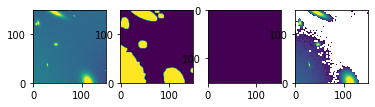

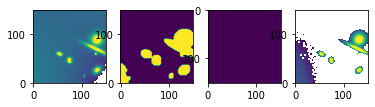

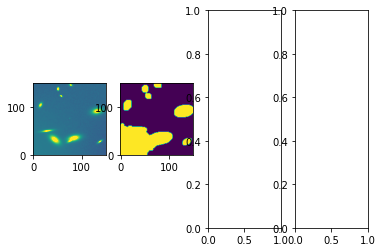

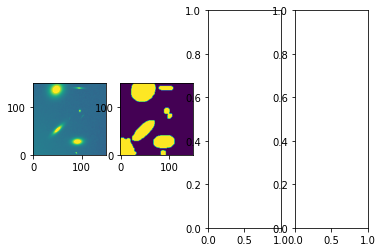

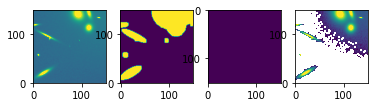

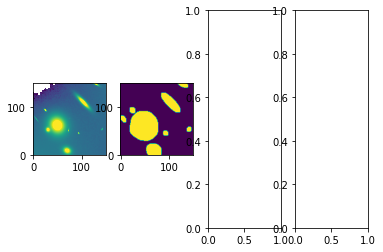

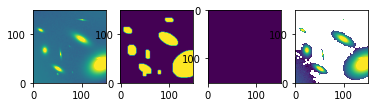

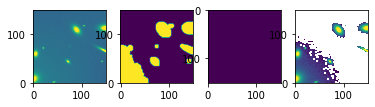

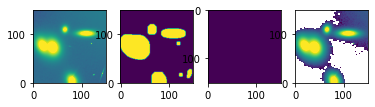

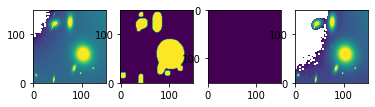

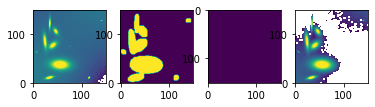

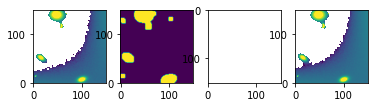

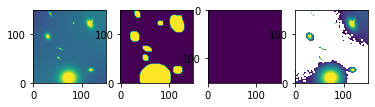

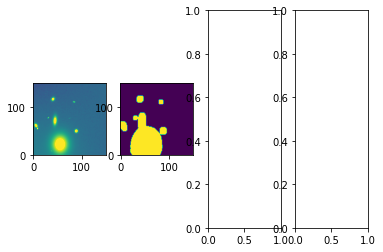

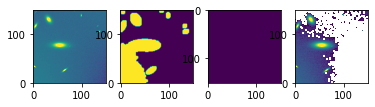

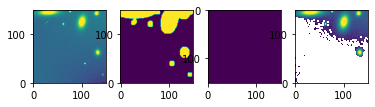

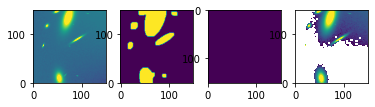

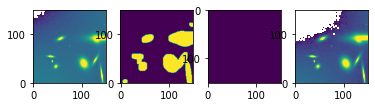

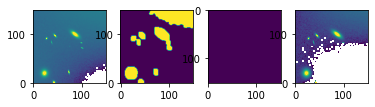

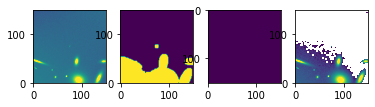

In [5]:
for cutout in gradient_added_models.cutouts:
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(np.log10(cutout), vmin=-2, vmax=1, origin='lower')
    try:
        mask = gp.bgsub_source_mask(cutout, gp.default_config())
        ax[1].imshow(mask, origin='lower')

    except Exception as e:
        print(f"Failed to create mask: {e} ")
    try:
        sm, bkg = gp.estimate_background_2D(cutout, config=gp.default_config())
        ax[2].imshow(np.log10(bkg.background))

        ax[3].imshow(np.log10(cutout - bkg.background), vmin=-2, vmax=1, origin='lower')
    except Exception as e:
        print(f"Failed to estimate background: {e} ")